# Download libraries

In [7]:
!pip install gdown -q
!pip install segmentation-models-pytorch -q
!pip install torchmetrics -q

In [8]:
seed = 27

# Installing Data

In [9]:
# train and Val
DATASET_PATH = "1mWY8_dins5txSqKR0NlOiBnwh7kc5zNA"
!gdown -q $DATASET_PATH -O trainval.zip
!unzip -q trainval.zip

In [70]:
DATASET_PATH = "1nqTb1AHYhJyy2wPNLFXPzNg4EwBej0kd"
!gdown -q $DATASET_PATH -O testset_psyko.zip
!unzip -q testset_psyko.zip

# Install Libraries

In [11]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from random import shuffle
import scipy.misc
from PIL import Image
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import cv2
import os
import glob
from tqdm.notebook import tqdm
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score
import random
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
import cv2

# Reading images

In [12]:
# Directory containing the images
data_dir = "./"

# Initialize lists to store file paths and labels
file_paths_A = []
file_paths_B = []
file_paths_label = []

# Iterate through images in folder A
for filename in os.listdir(os.path.join(data_dir, "trainval", "A")):
    file_paths_A.append(os.path.join(data_dir, "trainval", "A", filename))

# Iterate through images in folder B
for filename in os.listdir(os.path.join(data_dir, "trainval", "B")):
    file_paths_B.append(os.path.join(data_dir, "trainval", "B", filename))

# Iterate through images in label folder
for filename in os.listdir(os.path.join(data_dir, "trainval", "label")):
    file_paths_label.append(os.path.join(data_dir, "trainval", "label", filename))

# Create DataFrame
df = pd.DataFrame({"file_path_A": file_paths_A,
                   "file_path_B": file_paths_B,
                   "file_path_label": file_paths_label})



In [13]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)

In [14]:
val_df['state'] = 0

In [15]:
filter_floor_arr = []

for index, item in train_df.iterrows():
    mask_item = item['file_path_label']
    mask_img = np.array(Image.open(mask_item))
    if np.all(mask_img == 0):
        filter_floor_arr.append(item)

df_filter_floor = pd.DataFrame(filter_floor_arr)

In [16]:
df_filter_floor.head(5)

,file_path_A,file_path_B,file_path_label
2505,./trainval/A/3093.png,./trainval/B/3093.png,./trainval/label/3093.png
151,./trainval/A/2007.png,./trainval/B/2007.png,./trainval/label/2007.png
1634,./trainval/A/1201.png,./trainval/B/1201.png,./trainval/label/1201.png
4607,./trainval/A/1122.png,./trainval/B/1122.png,./trainval/label/1122.png
1882,./trainval/A/2571.png,./trainval/B/2571.png,./trainval/label/2571.png


In [17]:
train_df.head()

,file_path_A,file_path_B,file_path_label
2505,./trainval/A/3093.png,./trainval/B/3093.png,./trainval/label/3093.png
151,./trainval/A/2007.png,./trainval/B/2007.png,./trainval/label/2007.png
3815,./trainval/A/4169.png,./trainval/B/4169.png,./trainval/label/4169.png
2634,./trainval/A/4662.png,./trainval/B/4662.png,./trainval/label/4662.png
754,./trainval/A/3688.png,./trainval/B/3688.png,./trainval/label/3688.png


In [18]:
remaining_df = train_df.drop(df_filter_floor.index).reset_index(drop=True)

In [19]:
remaining_df.head(5)

,file_path_A,file_path_B,file_path_label
0,./trainval/A/4169.png,./trainval/B/4169.png,./trainval/label/4169.png
1,./trainval/A/4662.png,./trainval/B/4662.png,./trainval/label/4662.png
2,./trainval/A/3688.png,./trainval/B/3688.png,./trainval/label/3688.png
3,./trainval/A/4729.png,./trainval/B/4729.png,./trainval/label/4729.png
4,./trainval/A/4572.png,./trainval/B/4572.png,./trainval/label/4572.png


In [20]:
df_filter_floor = df_filter_floor.reset_index(drop=True)

In [21]:
df_filter_floor['state'] = 0

In [22]:
print(f'length df : {len(train_df)}')
print(f'length filtered : {len(df_filter_floor)}')
print(f'length remove filtered : {len(remaining_df)}')
print(f'removed + filter: {len(df_filter_floor) + len(remaining_df)}')

length df : 3894
length filtered : 2599
length remove filtered : 1295
removed + filter: 3894


In [23]:
df_cleaned_arr = []
# Loop over the DataFrame row by row
for index, item in remaining_df.iterrows():
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': 0
    }
    df_cleaned_arr.append(row)
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': 1
    }
    df_cleaned_arr.append(row)
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': 2
    }
    df_cleaned_arr.append(row)
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': 3
    }
    df_cleaned_arr.append(row)
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': 4
    }
    df_cleaned_arr.append(row)
    row = {
        'file_path_A': item['file_path_A'],
        'file_path_B': item['file_path_B'],
        'file_path_label': item['file_path_label'],
        'state': 5
    }
    df_cleaned_arr.append(row)

df_cleaned = pd.DataFrame(df_cleaned_arr)

In [24]:
df_cleaned.head(5)

,file_path_A,file_path_B,file_path_label,state
0,./trainval/A/4169.png,./trainval/B/4169.png,./trainval/label/4169.png,0
1,./trainval/A/4169.png,./trainval/B/4169.png,./trainval/label/4169.png,1
2,./trainval/A/4169.png,./trainval/B/4169.png,./trainval/label/4169.png,2
3,./trainval/A/4169.png,./trainval/B/4169.png,./trainval/label/4169.png,3
4,./trainval/A/4169.png,./trainval/B/4169.png,./trainval/label/4169.png,4


In [25]:
print(f'length of df_cleaned: {len(df_cleaned)}')

length of df_cleaned: 7770


In [26]:
# Concatenate the df_filter_floor back to the original DataFrame
new_df = pd.concat([df_cleaned, df_filter_floor], ignore_index=True)

384
 file A is ./trainval/A/1762.png
 file B is ./trainval/B/1762.png
 file Label is ./trainval/label/1762.png
(256, 256, 3)
(256, 256, 3)
(256, 256)


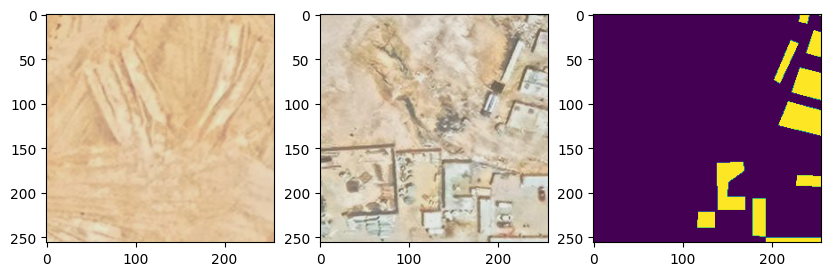

In [27]:
# read a random sample - two set of images and the associated change mask
sample = np.random.randint(0,len(train_df))
# sample = 2005
print(sample)

fileA, fileB, fileL, _ = new_df.iloc[sample]

print(f' file A is {fileA}')
print(f' file B is {fileB}')
print(f' file Label is {fileL}')

im1 = Image.open(fileA)
im2 = Image.open(fileB)
lab = Image.open(fileL)

print(np.array(im1).shape)
print(np.array(im2).shape)
print(np.array(lab).shape)

fig,ax = plt.subplots(1,3,figsize=(10,10))

ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(lab)

In [28]:
print(np.array(lab))

[[  0   0   0 ... 255 255 255]
 [  0   0   0 ...   0 255 255]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]


# Start data set and the model

In [29]:
# def adjust_brightness(img, target_brightness=210):
# #     img = cv2.convertScaleAbs(img)

#     # Convert image to HSV color space
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     # Split the channels
#     h, s, v = cv2.split(hsv)
#     # print(v)
#     # Compute the average brightness of the image
#     avg_brightness = v.mean()
    
#     # Compute the difference in brightness
#     brightness_diff = target_brightness - avg_brightness
    
#     # Adjust the brightness of the image
#     v_adjusted = cv2.add(v, brightness_diff)
    
#     # Clip values to ensure they are within valid range [0, 255]
#     v_adjusted = np.clip(v_adjusted, 0, 255)
    
#     # Merge the channels back together
#     adjusted_hsv = cv2.merge([h, s, v_adjusted])
    
#     # Convert back to BGR color space
#     adjusted_img = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2BGR)
    
#     return adjusted_img

In [30]:
class ChangeDataset():
    def __init__(self,df_data):
        
        self.df_data = df_data

    def __len__(self):
        
        return (len(self.df_data))

    def __getitem__(self,item):

        fileA, fileB, fileL, state = self.df_data.iloc[item]

        im1=cv2.imread(fileA)
        im1 = TF.to_tensor(im1) / 255

        im2 = cv2.imread(fileB)
        im2 = TF.to_tensor(im2) / 255

        target = Image.open(fileL)
        
        # Convert target to tensor
        target = torch.tensor(np.array(target), dtype=torch.float)

        # Normalize to range [0, 1]
        target = target / 255

        # Convert to long tensor
        target = target.to(dtype=torch.long)
        
        # If state = 1, mirror the images vertically
        if state == 1:
            im1 = TF.vflip(im1)
            im2 = TF.vflip(im2)
            target = TF.vflip(target)

        # If state = 2, mirror the images horizontally
        elif state == 2:
            im1 = TF.hflip(im1)
            im2 = TF.hflip(im2)
            target = TF.hflip(target)
            
        elif state == 3:
            im1 = torch.rot90(im1, k=1, dims=(1, 2))
            im2 = torch.rot90(im2, k=1, dims=(1, 2))
            target = torch.rot90(target, k=1, dims=(0, 1))
            
        elif state == 4:
            im1 = torch.rot90(im1, k=2, dims=(1, 2))
            im2 = torch.rot90(im2, k=2, dims=(1, 2))
            target = torch.rot90(target, k=2, dims=(0, 1))
    
        elif state == 5:
            im1 = torch.rot90(im1, k=3, dims=(1, 2))
            im2 = torch.rot90(im2, k=3, dims=(1, 2))
            target = torch.rot90(target, k=3, dims=(0, 1))
            
        target = target.squeeze()
        

        return im1, im2, target

In [31]:
train_ds = ChangeDataset(new_df)
val_ds = ChangeDataset(val_df)
test_floor_ds = ChangeDataset(df_filter_floor)

6054


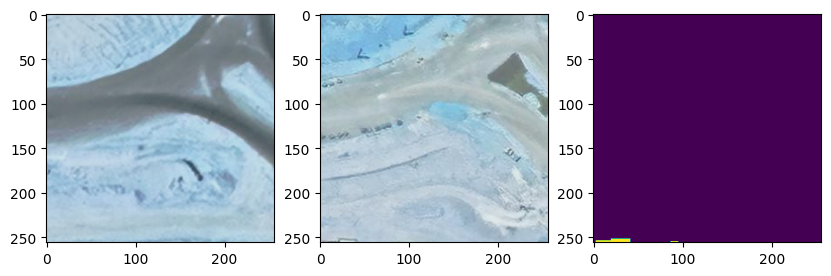

In [32]:
sample = np.random.randint(0,len(train_ds))

print(sample)

im1,im2,target = train_ds[sample] # read a random sample

im1.shape,im2.shape,target.shape  # check shape

# plot the image1, image2 and the change mask
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1.numpy().transpose(1,2,0) * 255)
ax[1].imshow(im2.numpy().transpose(1,2,0) * 255)
ax[2].imshow(target.numpy())

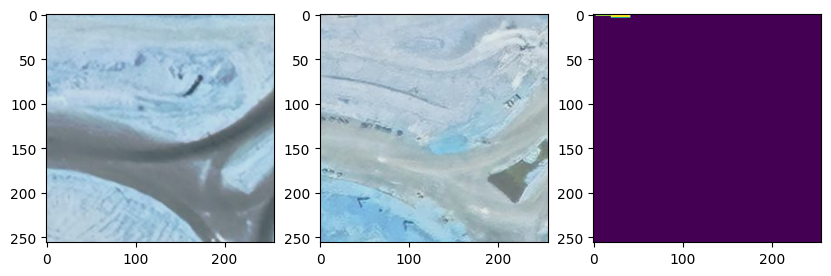

In [33]:
sample = sample + 1

im1,im2,target = train_ds[sample] # read a random sample

im1.shape,im2.shape,target.shape  # check shape
# plot the image1, image2 and the change mask
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1.numpy().transpose(1,2,0) * 255)
ax[1].imshow(im2.numpy().transpose(1,2,0) * 255)
ax[2].imshow(target.numpy() * 255)

In [34]:
train_dl = DataLoader(train_ds,batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds,batch_size=1, shuffle=False)
test_floor_dl = DataLoader(test_floor_ds,batch_size=1, shuffle=False)

In [35]:
for i,j,k in train_dl:
  print(i.shape)
  print(j.shape)
  print(k.shape)
  break

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 256, 256])


In [36]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [37]:
model = smp.UnetPlusPlus('se_resnet101', encoder_depth=5, decoder_channels=(256, 128, 64, 32, 16))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth" to /root/.cache/torch/hub/checkpoints/se_resnet101-7e38fcc6.pth
100%|██████████| 189M/189M [09:15<00:00, 356kB/s]  


In [38]:
class ChangeNet(nn.Module):
    def __init__(self, model):
        super(ChangeNet, self).__init__()
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.head = model.segmentation_head

       

    def forward(self, x1, x2):
        # Get latent features of both images
        enc1 = self.encoder(x1)
        enc2 = self.encoder(x2)

        # Combine features using element-wise subtraction to emphasize changes
        encoder_out = [torch.abs(e1 - e2) for e1, e2 in zip(enc1, enc2)]


        # Pass the latent features through the decoder
        decoder_out = self.decoder(*encoder_out)

        # Pass the decoder output through the segmentation head to generate change mask
        out = self.head(decoder_out)

        # Apply sigmoid activation to output for binary change mask
        return out

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print(device)

cuda


In [40]:
change_model = ChangeNet(model).to(device) #migrating model to device

In [41]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=0).sum(dim=0)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=0).sum(dim=0) + target.sum(dim=0).sum(dim=0) + smooth)))

    return loss.mean()

def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

In [42]:
criterion = calc_loss

In [43]:
# Define the parameters
learning_rate = 0.0001
betas = (0.9, 0.999)
weight_decay = 0.0001
eps = 1e-8

# Initialize the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay, eps=eps)

In [44]:
epoc_num = 2
model_path = './model.pt'
best_dev_js = 0

In [45]:
train_jaccard = JaccardIndex(num_classes=2, task='binary')
valid_jaccard = JaccardIndex(num_classes=2, task='binary')
test_floor_jaccard = JaccardIndex(num_classes=2, task='binary')

for epoch in tqdm(range(epoc_num)):  # Number of epochs = 10

    epoch_loss = []
    j_score = []
    
    train_jaccard.reset()
    valid_jaccard.reset()
    test_floor_jaccard.reset()
    
    tp = 0
    fp = 0
    fn = 0
    
    tp_V = 0
    fp_V = 0
    fn_V = 0
    
    tp_T2 = 0
    fp_T2 = 0
    fn_T2 = 0
    
    # Iterate over data.
    change_model.train() # setting model state to train
    for x1, x2, target in tqdm(train_dl,total=len(train_dl)):

        x1 = x1.to(device)  #migrating inputs to device
        x2 = x2.to(device)  #migrating inputs to device

        target = target.to(device)  #migrating inputs to device

        # zero the parameter gradients
        optimizer.zero_grad()   #resetting the optimizer

        # forward
        outputs = change_model(x1,x2)  # generating model predictions
        loss = criterion(outputs.squeeze(), target.float().squeeze()) # evaluating loss

        # backward + optimize only if in training phase

        loss.backward()  # calculating gradients
        optimizer.step()  # using optimizer to recalculate parameters
        epoch_loss.append(loss.item())

        # Ensure the number of elements in both tensors is the same
        assert target.numel() == outputs.numel(), "Inconsistent numbers of samples between target and output"

        # Flatten the tensors
        target_flat = target.view(-1).detach().cpu()
        output_flat = (torch.sigmoid(outputs).squeeze() > 0.5).view(-1).detach().cpu()
        
        # Calculate tp, fp, fn
        tp += ((output_flat == 1) & (target_flat == 1)).sum().item()
        fp += ((output_flat == 1) & (target_flat == 0)).sum().item()
        fn += ((output_flat == 0) & (target_flat == 1)).sum().item()
        
        # Training step Jaccard score
        train_jaccard.update(target_flat, output_flat)
        
        target_flat = target_flat.numpy()
        output_flat = output_flat.numpy()

        # Compute Jaccard score
        js = jaccard_score(target_flat, output_flat, zero_division=1)
        j_score.append(js)
    ###################################################### Validation ######################################################
    # Initialize list to store Jaccard scores
    Val_j_score = []

    # Set the model to evaluation mode
    change_model.eval()
    # No need to track gradients in test mode
    with torch.no_grad():
        for x1, x2, target in tqdm(val_dl, total=len(val_dl)):
            x1 = x1.to(device)
            x2 = x2.to(device)
            target = target.to(device)

            # Forward pass
            outputs = change_model(x1, x2)

            # Flatten the tensors
            target_flat = target.view(-1).detach().cpu()
            output_flat = (torch.sigmoid(outputs).squeeze() > 0.5).view(-1).detach().cpu()
            
            # Calculate tp, fp, fn
            tp_V += ((output_flat == 1) & (target_flat == 1)).sum().item()
            fp_V += ((output_flat == 1) & (target_flat == 0)).sum().item()
            fn_V += ((output_flat == 0) & (target_flat == 1)).sum().item()

            # Training step Jaccard score
            valid_jaccard.update(target_flat, output_flat)
            
            target_flat = target_flat.numpy()
            output_flat = output_flat.numpy()
            
            # Compute Jaccard score
            js = jaccard_score(target_flat, output_flat, zero_division=1)
            Val_j_score.append(js)

    ###################################################### test 2 floor ######################################################
    # Initialize list to store Jaccard scores
    test_floor_j_score_arr = []

    # Set the model to evaluation mode
    change_model.eval()
    # No need to track gradients in test mode
    with torch.no_grad():
        for x1, x2, target in tqdm(test_floor_dl, total=len(test_floor_dl)):
            x1 = x1.to(device)
            x2 = x2.to(device)
            target = target.to(device)

            # Forward pass
            outputs = change_model(x1, x2)

            # Flatten the tensors
            target_flat = target.view(-1).detach().cpu()
            output_flat = (torch.sigmoid(outputs).squeeze() > 0.5).view(-1).detach().cpu()
            
            # Calculate tp, fp, fn
            tp_T2 += ((output_flat == 1) & (target_flat == 1)).sum().item()
            fp_T2 += ((output_flat == 1) & (target_flat == 0)).sum().item()
            fn_T2 += ((output_flat == 0) & (target_flat == 1)).sum().item()

            # Training step Jaccard score
            test_floor_jaccard.update(target_flat, output_flat)
            
            target_flat = target_flat.numpy()
            output_flat = output_flat.numpy()
            
            # Compute Jaccard score
            js = jaccard_score(target_flat, output_flat, zero_division=1)
            test_floor_j_score_arr.append(js)
            
            

            

    # Print the average test Jaccard scores over all batches
    curr_dev = np.array(Val_j_score).mean()

    if curr_dev > best_dev_js:
        print('found a best dev:)')
        torch.save(change_model.state_dict(), model_path)
        best_dev_js = curr_dev

    print('----- Train Info')
    
    print(f"Epoch {epoch}, Loss:",np.array(epoch_loss).mean(), f"Jaccard score: ", np.array(j_score).mean())
    print(f'for each epoch jaccard score 2: train: {train_jaccard.compute()}')
    print(f'TP: {tp}, FP: {fp}, FN: {fn}')
    print(f'jaccard 3 train: {tp / (tp + fp + fn)}')
    
    print('----- Val Info')
    
    print("Val Jaccard score: ", curr_dev)
    print(f'for each epoch jaccard score 2: val: {valid_jaccard.compute()}')
    print(f'TP: {tp_V}, FP: {fp_V}, FN: {fn_V}')
    print(f'jaccard 3 val: {tp_V / (tp_V + fp_V + fn_V)}')
 
    print('----- Test Floor Info')
    
    print("test floor Jaccard score: ", np.array(test_floor_j_score_arr).mean())
    print(f'for each epoch jaccard score 2: test floor : {test_floor_jaccard.compute()}')
    print(f'TP: {tp_T2}, FP: {fp_T2}, FN: {fn_T2}')
    print(f'jaccard 3 test floor : {tp_T2 / (tp_T2 + fp_T2 + fn_T2)}')



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/649 [00:00<?, ?it/s]

  0%|          | 0/974 [00:00<?, ?it/s]

  0%|          | 0/2599 [00:00<?, ?it/s]

found a best dev:)
----- Train Info
Epoch 0, Loss: 0.31434181185643 Jaccard score:  0.6600009067559223
for each epoch jaccard score 2: train: 0.637493371963501
TP: 87657586, FP: 34468608, FN: 15377336
jaccard 3 train: 0.6374933501707193
----- Val Info
Val Jaccard score:  0.8251810129456357
for each epoch jaccard score 2: val: 0.6951078772544861
TP: 3654408, FP: 530126, FN: 1072791
jaccard 3 val: 0.6951078733005853
----- Test Floor Info
test floor Jaccard score:  0.9276644863409004
for each epoch jaccard score 2: test floor : 0.0
TP: 0, FP: 114162, FN: 0
jaccard 3 test floor : 0.0


  0%|          | 0/649 [00:00<?, ?it/s]

  0%|          | 0/974 [00:00<?, ?it/s]

  0%|          | 0/2599 [00:00<?, ?it/s]

----- Train Info
Epoch 1, Loss: 0.15170450879401529 Jaccard score:  0.7698371273265596
for each epoch jaccard score 2: train: 0.7727810740470886
TP: 90034527, FP: 13472237, FN: 13000395
jaccard 3 train: 0.7727810700456613
----- Val Info
Val Jaccard score:  0.761165124184187
for each epoch jaccard score 2: val: 0.6977570652961731
TP: 3991038, FP: 992611, FN: 736161
jaccard 3 val: 0.6977570933300232
----- Test Floor Info
test floor Jaccard score:  0.8514813389765294
for each epoch jaccard score 2: test floor : 0.0
TP: 0, FP: 507351, FN: 0
jaccard 3 test floor : 0.0


# Load Model

In [54]:
model_path_load = '/kaggle/input/model_50/pytorch/model_50/1/model2.pt'

In [55]:
change_model2 = ChangeNet(model).to(device) #migrating model to device
change_model2.load_state_dict(torch.load(model_path_load, map_location=device))
change_model2 = change_model2.to(device)

# Test Model

In [56]:
def show_images(images, titles=None):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(10*num_images, 5))

    for i in range(num_images):
        ax = axes[i] if num_images > 1 else axes  # Handle single image case
        ax.imshow(images[i])
        ax.axis('off')  # Hide axis for the image
        if titles:
            ax.set_title(titles[i])  # Set title if titles are provided

    plt.show()

In [57]:
  def otsu(data, num=400):
    max_value = np.max(data)
    min_value = np.min(data)

    total_num = data.size  # Use size instead of shape[1]
    step_value = (max_value - min_value) / num
    value = min_value + step_value
    best_threshold = min_value
    best_inter_class_var = 0
    while value <= max_value:
        data_1 = data[data <= value]
        data_2 = data[data > value]
        if data_1.size == 0 or data_2.size == 0:  # Use size instead of shape[0]
            value += step_value
            continue
        w1 = data_1.size / total_num  # Use size instead of shape[0]
        w2 = data_2.size / total_num  # Use size instead of shape[0]

        mean_1 = data_1.mean()
        mean_2 = data_2.mean()

        inter_class_var = w1 * w2 * np.power((mean_1 - mean_2), 2)
        if best_inter_class_var < inter_class_var:
            best_inter_class_var = inter_class_var
            best_threshold = value
        value += step_value

    return best_threshold

In [58]:
def confusion_and_metrics_heatmap(TP, FN, FP, TN):
    # Create combined matrix
    combined_matrix = np.array([[TP, FN], [FP, TN]])
    
    # Create annotations
    labels = np.asarray([["{0:0.0f}".format(item) for item in row] for row in combined_matrix])
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(combined_matrix, annot=labels, fmt="", cmap='coolwarm', linewidths=0.5, linecolor='black', cbar=False)
    
    # Set axis labels
    plt.xticks(ticks=np.arange(0.5, 2.5, 1), labels=['Predicted 1', 'Predicted 0'])
    plt.yticks(ticks=np.arange(0.5, 2.5, 1), labels=['Actual 1', 'Actual 0'])
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.show()


  0%|          | 0/974 [00:00<?, ?it/s]

Val Jaccard score:  0.8831334640532849
for Val data jaccard score 2: Val: 0.7962572574615479
Jaccard Score for class 3: 0.7962572354137493
---
TP: 4173646, FP: 514381, FN: 553553, TN58590484
---
Precision: 0.9372311824650706
Recall: 0.9317094210770301
F1 Score: 0.9135132886553159
Accuracy: 0.9832696307611172
---
Precision: 0.890277722376599
Recall: 0.8829004236969926
F1 Score: 0.8865737264299338
Accuracy: 0.9832696307611172
---


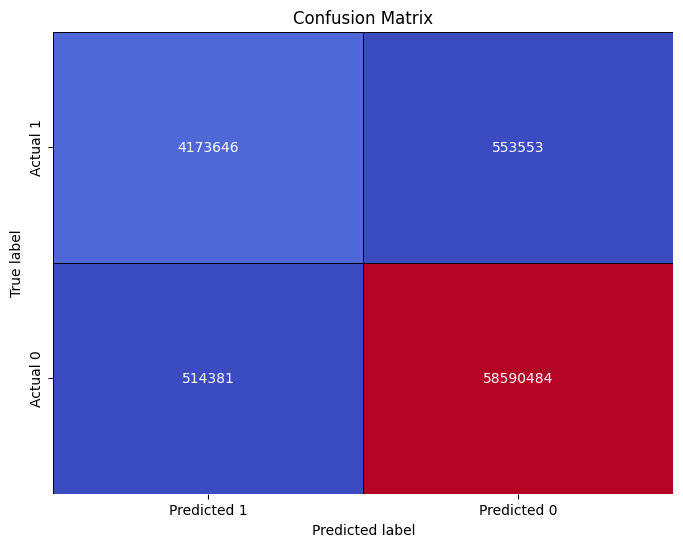

In [60]:
val_jaccard = JaccardIndex(num_classes=2, task='binary')
# Initialize list

acc_scores = []
pre_scores = []
rec_scores = []
f1_scores = []
val_j_scores = []

# Set the model to evaluation mode
change_model.eval()
# No need to track gradients in val mode
with torch.no_grad():
    
    val_jaccard.reset()
    
    tp_V = 0
    fp_V = 0
    fn_V = 0
    tn_V = 0
    
    for x1, x2, target in tqdm(val_dl, total=len(val_dl)):
        x1 = x1.to(device)
        x2 = x2.to(device)
        target = target.to(device)

        # Forward pass
        outputs = change_model(x1, x2)

        # Flatten the tensors
        target_flat = target.view(-1).detach().cpu()
        output_flat = (torch.sigmoid(outputs).squeeze() > 0.5).view(-1).detach().cpu()
        
        # Calculate tp, fp, fn
        tp_V += ((output_flat == 1) & (target_flat == 1)).sum().item()
        fp_V += ((output_flat == 1) & (target_flat == 0)).sum().item()
        fn_V += ((output_flat == 0) & (target_flat == 1)).sum().item()
        tn_V += ((output_flat == 0) & (target_flat == 0)).sum().item()

        
        # Training step Jaccard score
        val_jaccard.update(target_flat, output_flat)
        
        target_flat = target_flat.numpy()
        output_flat = output_flat.numpy()

        # Compute Jaccard score
        js = jaccard_score(target_flat, output_flat, zero_division=1)
        val_j_scores.append(js)
        
        acc_scores.append(accuracy_score(target_flat, output_flat))
        
        pre_scores.append(precision_score(target_flat, output_flat, zero_division=1)) 
        rec_scores.append(recall_score(target_flat, output_flat, zero_division=1)) 
        f1_scores.append(f1_score(target_flat, output_flat, zero_division=1)) 
        
    
# Print the average val Jaccard scores over all batches
print("Val Jaccard score: ", np.array(val_j_scores).mean())
print(f'for Val data jaccard score 2: Val: {val_jaccard.compute()}')
# Calculate Jaccard score for class 3 with zero division set to 1
jaccard_val_3 = tp_V / (tp_V + fp_V + fn_V) if (tp_V + fp_V + fn_V) != 0 else 1
print(f'Jaccard Score for class 3: {jaccard_val_3}')
print('---')
print(f'TP: {tp_V}, FP: {fp_V}, FN: {fn_V}, TN{tn_V}')
print('---')
# Print the metrics
print(f'Precision: {np.array(pre_scores).mean()}')
print(f'Recall: {np.array(rec_scores).mean()}')
print(f'F1 Score: {np.array(f1_scores).mean()}')
print(f'Accuracy: {np.array(acc_scores).mean()}')
print('---')
# Calculate precision, recall, F1-score, and accuracy with handling zero division
if tp_V + fp_V != 0:
    precision2 = tp_V / (tp_V + fp_V)
else:
    precision2 = 0  # or any other default value you prefer

if tp_V + fn_V != 0:
    recall2 = tp_V / (tp_V + fn_V)
else:
    recall2 = 0  # or any other default value you prefer

if precision2 + recall2 != 0:
    f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
else:
    f1_score2 = 0  # or any other default value you prefer
    
accuracy2 = (tp_V + tn_V) / (tp_V + fp_V + fn_V + tn_V)

# Print the metrics
print(f'Precision: {precision2}')
print(f'Recall: {recall2}')
print(f'F1 Score: {f1_score2}')
print(f'Accuracy: {accuracy2}')
print('---')

# Call the function with the provided values
confusion_and_metrics_heatmap(tp_V, fn_V, fp_V, tn_V)

In [61]:
#####################################################################################

# Generate Test Maks

In [71]:
# Directory containing the images
data_dir = "./"

# Initialize lists to store file paths and labels
file_paths_A = []
file_paths_B = []

# Iterate through images in folder A
for filename in os.listdir(os.path.join(data_dir, "test", "A")):
    file_paths_A.append(os.path.join(data_dir, "test", "A", filename))

# Iterate through images in folder B
for filename in os.listdir(os.path.join(data_dir, "test", "B")):
    file_paths_B.append(os.path.join(data_dir, "test", "B", filename))

# Create DataFrame
test_df_tsleemt_mo3eed = pd.DataFrame({"file_path_A": file_paths_A,
                           "file_path_B": file_paths_B})


In [72]:
test_df_tsleemt_mo3eed.head()

,file_path_A,file_path_B
0,./test/A/0288.png,./test/B/0288.png
1,./test/A/0262.png,./test/B/0262.png
2,./test/A/0086.png,./test/B/0086.png
3,./test/A/0164.png,./test/B/0164.png
4,./test/A/0202.png,./test/B/0202.png


In [73]:
class TestDataset():
    def __init__(self,df_data):
        self.df_data = df_data

    def __len__(self):
        return (len(self.df_data))

    def __getitem__(self,item):

        fileA, fileB = self.df_data.iloc[item]

        im1=cv2.imread(fileA)
        im1 = TF.to_tensor(im1) / 255

        im2=cv2.imread(fileB)
        im2 = TF.to_tensor(im2) / 255

        return im1, im2, fileA, fileB

In [74]:
test_set_mo3eed = TestDataset(test_df_tsleemt_mo3eed)

In [75]:
os.mkdir('/kaggle/working/test/label_true')

In [76]:
change_model.eval()  

for idx, (img1, img2, fileA, fileB) in enumerate(test_set_mo3eed):
    with torch.no_grad():

        # Forward pass
        output = change_model(img1.unsqueeze(dim=0).to(device), img2.unsqueeze(dim=0).to(device))
        
        ground_truth = torch.sigmoid(output).squeeze() > 0.5
        ground_truth = ground_truth.detach().cpu().numpy().astype(np.uint8)
        ground_truth[ground_truth == 1] = 255
        cv2.imwrite(f'/kaggle/working/test/label_true/{os.path.basename(fileA)}', ground_truth)
   

In [77]:
!zip -r tsleem_file.zip /kaggle/working/test -q